# Preamble

In [1]:
%load_ext autoreload
%autoreload 2

# disable parallelization for BLAS and co.
from nalabtools.utils.parallelization import set_threads_for_external_libraries
set_threads_for_external_libraries(n_threads=1)

# general
import re
import collections
import pickle

# data
import numpy as np
import pandas as pd

# ml / stats
import scipy
import sklearn
import statsmodels.stats.multitest

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# nalab
import nalabtools

# init notebook files
import nalabtools.utils.misc
nb = nalabtools.utils.misc.NotebookContext("butterfly___martin_005_deepinsight")

# init matplotlib defaults (for Nima)
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [23]:
import time

In [3]:
def format_duration(totsec):
    h = totsec//3600
    m = (totsec%3600) // 60
    sec =(totsec%3600)%60 #just for reference
    print("%dh %dm %ds" %(h,m,sec))

In [4]:
import rpy2
rpy2.__version__

'3.1.0'

In [5]:
%load_ext rpy2.ipython

/home/mgbckr/miniconda3/envs/analysis3.7/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [6]:
%%R
R.home()

[1] "/home/mgbckr/miniconda3/envs/analysis3.7/lib/R"


# Load data

In [7]:
import pathlib
import nalabdata.fcs.load
import nalabdata.fcs.meta

In [ ]:
overwrite = True

# immune clock
tmp_fcs_path = pathlib.Path(nb.file("tmp_fcs_immuneclock.pickle"))
if not overwrite and tmp_fcs_path.exists():

    print("Loading from temp file")
    data_immuneclock_meta, data_immuneclock_fcs = pickle.load(open(path, "rb"))
    
else:
    
    print("Loading from FCS files; this may take a while ...")
    
    path = pathlib.Path("../data/_large/fcs/immune_clock/AllImmuneClock")
    files = list((path / "Training").glob("*")) + list((path / "Validation").glob("*"))

    selected_files = files
    data_immuneclock_meta = nalabdata.fcs.meta.meta_from_filenames(selected_files, context="immune_clock")
    data_immuneclock_fcs = nalabdata.fcs.load.load_fcs(
        selected_files,  
#         cell_filter="granulocytes", 
        n_cells_sample=10000,
        n_jobs=64)
    
    pickle.dump((data_immuneclock_meta, data_immuneclock_fcs), open(tmp_fcs_path, "wb"))
    
print("Done")

Loading from FCS files; this may take a while ...


R[write to console]: Loading required package: foreach

R[write to console]: Loading required package: iterators

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following object is masked from ‘package:flowCore’:

    filter


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
print("done")

In [118]:
# data_immuneclock_fcs

In [117]:
# data_immuneclock_meta

# Postprocessing


In [ ]:
columns_immuneclock = nalabdata.fcs.load.filter_columns(data_immuneclock_fcs.columns)

In [133]:
data_immuneclock_fcs_post = data_immuneclock_fcs.copy()

In [134]:
# scale each patient
# data_immuneclock_fcs_post = data_immuneclock_fcs_post.groupby(level=0).apply(
#     lambda df: pd.DataFrame(sklearn.preprocessing.RobustScaler().fit_transform(df.values), columns=df.columns))

In [135]:
import sklearn.pipeline
import sklearn.compose
preprocessing = sklearn.pipeline.make_pipeline(
    # select relevant columns
    sklearn.compose.ColumnTransformer([("filter", "passthrough", [c in columns_immuneclock for c in data_immuneclock_fcs.columns])]),
    # 0 - 1
    sklearn.preprocessing.MinMaxScaler()
)

In [136]:
preprocessing.fit(data_immuneclock_fcs.values)
data_features = preprocessing.transform(data_immuneclock_fcs_post.values)

## Batch correction

In [167]:
batches, idx = data_immuneclock_meta.loc[data_immuneclock_fcs.index, "group"].factorize()

In [224]:
%%R -i data_features -i batches -o corrected
library(limma)
corrected <- t(removeBatchEffect(t(data_features), batches))

In [202]:
%%R -i data_features -i batches -o corrected
library(sva)
corrected <- t(ComBat(t(data_features), batches))

R[write to console]: Found2batches

R[write to console]: Adjusting for0covariate(s) or covariate level(s)



Standardizing Data across genes


R[write to console]: Fitting L/S model and finding priors

R[write to console]: Finding parametric adjustments

R[write to console]: Adjusting the Data




In [225]:
data_features = corrected

# Derive images

In [226]:
# sklearn.preprocessing.LabelEncoder().fit_transform(data_fcs.index.values)
# data_fcs.index.values == data_fcs.index.values[0]
# data_fcs.index.factorize()

In [227]:
import fitsne
import butterfly.deepinsight.album2

start = time.time()

t = butterfly.deepinsight.album2.SingleCellTransformer(
    size=128, 
    embedding_algorithm=lambda X: fitsne.FItSNE(np.ascontiguousarray(X), nthreads=64),
#     embedding_algorithm=None,
    store_embeddings=True,
    means=True)
X_album = t.fit_transform(data_features, data_immuneclock_fcs.index.values)

duration = time.time() - start

Embedding
Rotating


group:     0, row:   0: : 0it [00:00, ?it/s]/home/mgbckr/mnt/nalab/workspaces/nalab-butterfly/src/butterfly/deepinsight/album2.py:220: RuntimeWarning: Mean of empty slice.
  album[i_g, 1:, i, j] = group_data[feature_idx, :].mean(axis=0)
/home/mgbckr/miniconda3/envs/analysis3.7/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
group:     0, row:   7: : 0it [00:00, ?it/s]

Images


group:   123, row: 127: : 124it [06:07,  2.97s/it]


In [228]:
format_duration(duration)

0h 39m 11s


In [229]:
print("test")

test


In [230]:
# plt.scatter(t.X_embedded_[:,0], t.X_embedded_[:,1])

# plt.figure()
# plt.scatter(t.X_rotated_[:,0], t.X_rotated_[:,1])
# sns.heatmap(X_album[0, 0, :])

# plt.figure()
# sns.heatmap(np.log(X_album[1, 0, :]))

In [231]:
def plot_photos(d=0, selected=5, plot=True, plot_log=True, random_state="head"):
    
    if isinstance(selected, int):
        if random_state == "head":
            selected = list(range(selected))
        else:
            if random_state != "random":
                rs = np.random.RandomState(random_state)
            else:
                rs = np.random.RandomState()
            selected = sorted(rs.randint(0, X_album.shape[0], selected))
        
    if plot:
        fig, axes = plt.subplots(1, len(selected), figsize=(len(selected) * (4 + .5), 4), sharey=True, sharex=True)
        for i, s in enumerate(selected):
            ax = axes[i]
            sns.heatmap(X_album[s, d, :], ax=ax, cbar=s == selected[-1])
            ax.set_title(s)
        
    if plot_log:
        fig, axes = plt.subplots(1, len(selected), figsize=(len(selected) * (4 + .5), 4), sharey=True, sharex=True)
        for i, s in enumerate(selected):
            ax = axes[i]
            sns.heatmap(np.log10(X_album[s, d, :] + 0.00001), ax=ax, cbar=s == selected[-1])
            ax.set_title(s)

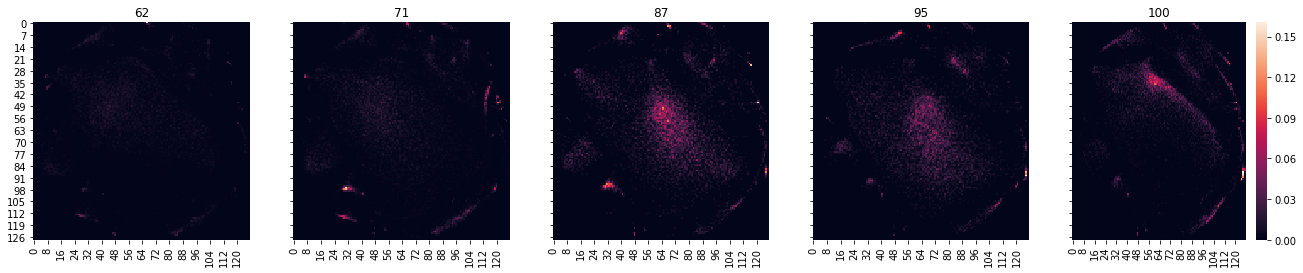

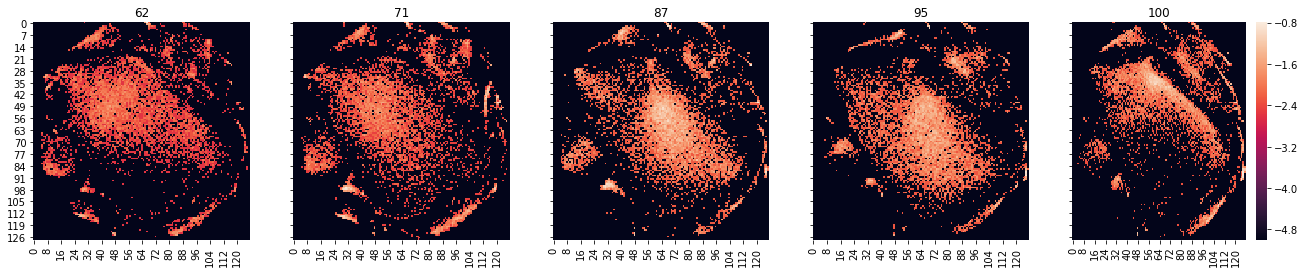

In [232]:
plot_photos(d=0, selected=5, random_state=None)

/home/mgbckr/miniconda3/envs/analysis3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log10


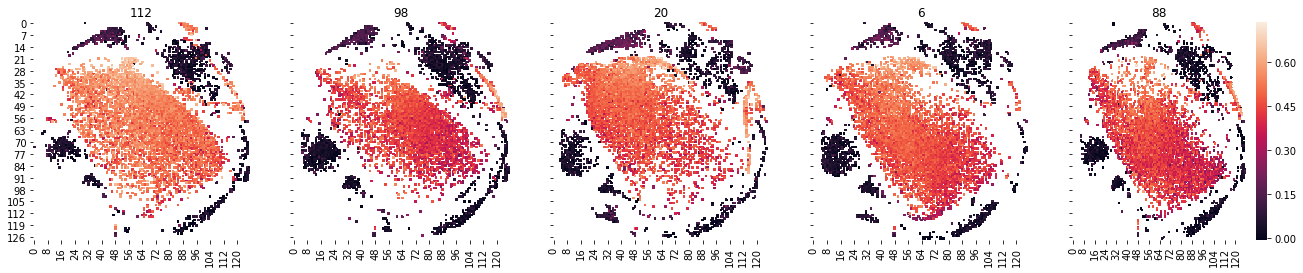

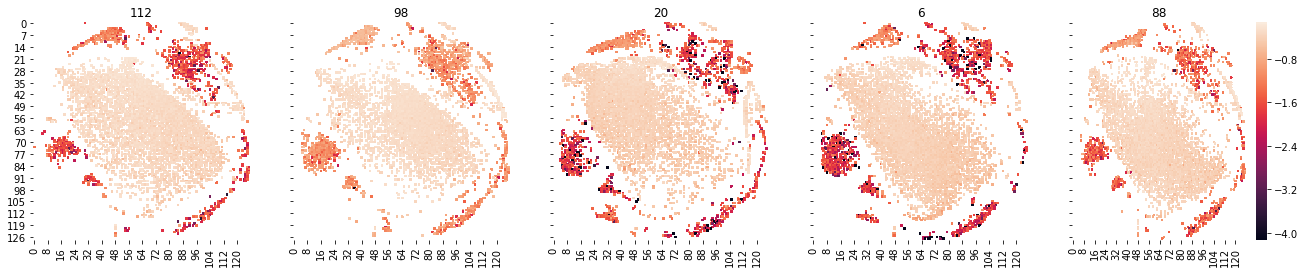

In [233]:
plot_photos(d=33, selected=[112,98,20,6,88], random_state=None)

In [234]:
data_immuneclock_meta.sort_values(["patient", "timepoint"]).iloc[[75, 80, 99],]

,group,patient,cell_range,stimulation,timepoint,gestational_age_delivery,gestational_age_sample,filename,path
file_index,,,,,,,,,
70,training,ptlg022,cd235-cd61-,unstim,4,37,43,Gates_PTLG022_3_Unstim_CD235-CD61-_unstim_pp__...,../data/_large/fcs/immune_clock/AllImmuneClock...
81,training,ptlg024,cd235-cd61-,unstim,1,39,11,Gates_PTLG024_BL_Unstim_CD235-CD61-_unstim_1st...,../data/_large/fcs/immune_clock/AllImmuneClock...
103,validation,ptlg028,cd235-cd61-,unstim,4,40,48,Gates_PTLG028_3_Unstim_CD235-CD61-_Unstim_3__p...,../data/_large/fcs/immune_clock/AllImmuneClock...


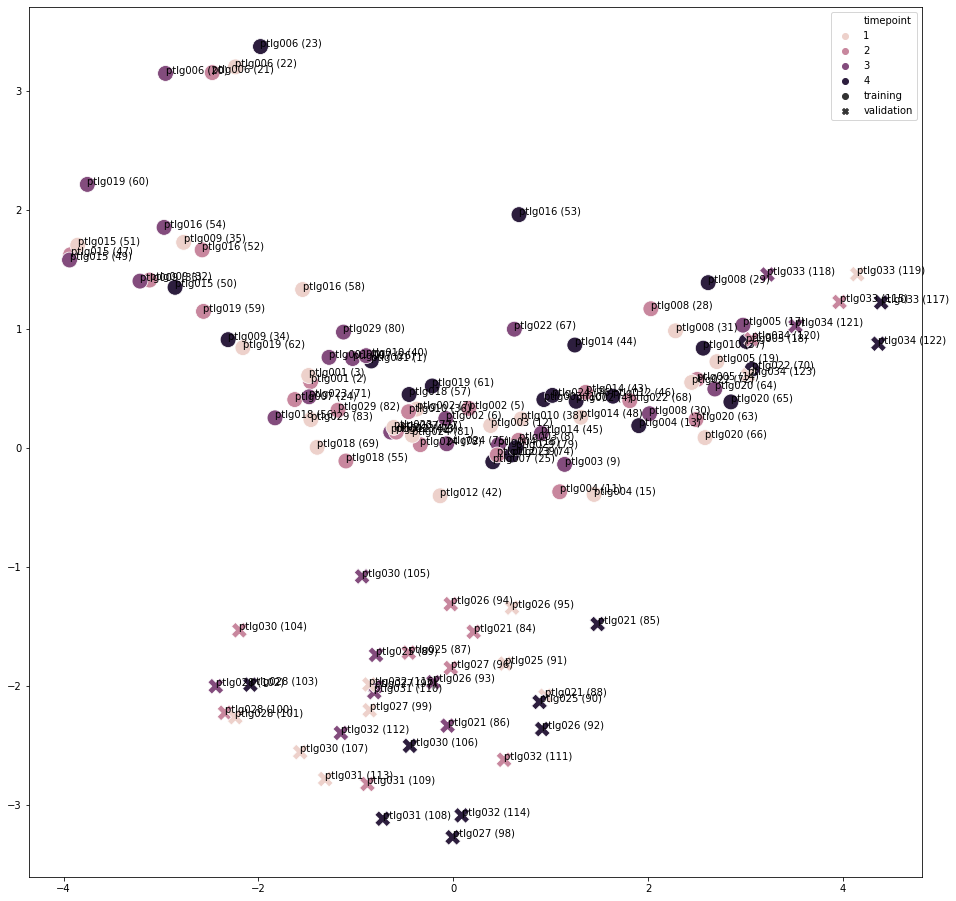

In [235]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA(n_components=10)
a = X_album[:,1,:,:].reshape((-1, 128 * 128))
a[np.isnan(a)] = 0
emb = pca.fit_transform(a)
plt.figure(figsize=(16,16))
sns.scatterplot(emb[:,0], emb[:,1], hue=data_immuneclock_meta.timepoint, s=250, style=data_immuneclock_meta.group.values)
for i in range(emb.shape[0]):
    plt.annotate(f"{data_immuneclock_meta.patient.values[i]} ({i})", (emb[i,0], emb[i,1]))

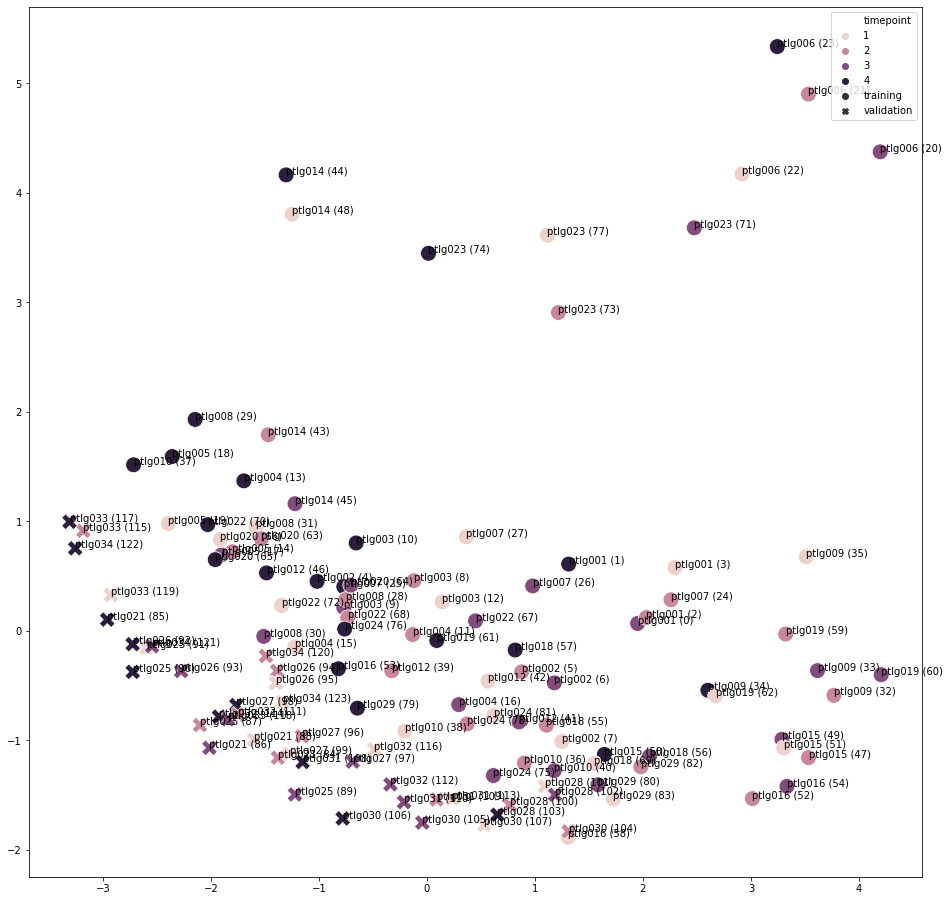

In [223]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA(n_components=10)
a = X_album[:,1,:,:].reshape((-1, 128 * 128))
a[np.isnan(a)] = 0
emb = pca.fit_transform(a)
plt.figure(figsize=(16,16))
sns.scatterplot(emb[:,0], emb[:,1], hue=data_immuneclock_meta.timepoint, s=250, style=data_immuneclock_meta.group.values)
for i in range(emb.shape[0]):
    plt.annotate(f"{data_immuneclock_meta.patient.values[i]} ({i})", (emb[i,0], emb[i,1]))

# Prepare task

In [106]:
# t1 / t2 task
select_t1_t2 = np.array([b in [1,2] for a,b in data_fcs.index.drop_duplicates().values])
X_album_t1_t2 = X_album[select_t1_t2,:]
y_t1_t2 = np.array([b == 2 for _,b in data_fcs.index.drop_duplicates().values[select_t1_t2]])
groups_t1_t2 = np.array([a for a,_ in data_fcs.index.drop_duplicates().values[select_t1_t2]])

In [423]:
import nalabtools.sklearn.model_selection

X = X_album_t1_t2
y = y_t1_t2
groups = groups_t1_t2

splits_test = sklearn.model_selection.GroupShuffleSplit(n_splits=1, test_size=0.10).split(X.reshape(X.shape[0], -1), y, groups=groups)
# splits_test = sklearn.model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.10).split(X.reshape(X.shape[0], -1), y, groups=groups)
remain_idx, test_idx = next(splits_test)

X_remain = X[remain_idx,:]
y_remain = y[remain_idx]
groups_remain = groups[remain_idx]

X_test = X[test_idx,:]
y_test = y[test_idx]

splits_val = sklearn.model_selection.GroupShuffleSplit(n_splits=1, test_size=0.10).split(X_remain.reshape(X_remain.shape[0], -1), y_remain, groups=groups_remain)
# splits_val = sklearn.model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.10).split(X_remain.reshape(X_remain.shape[0], -1), y_remain, groups=groups_remain)
train_idx, val_idx = next(splits_val)

# X_train = X_remain[train_idx, :]
# y_train = y_remain[train_idx]
X_train = X_remain
y_train = y_remain
X_val = X_test
y_val = y_test

In [424]:
import torch.utils.data
dataset_train = butterfly.deepinsight.album2.AlbumDataset(X_train, y_train)
dataset_val = butterfly.deepinsight.album2.AlbumDataset(X_val, y_val)
dataset_test = butterfly.deepinsight.album2.AlbumDataset(X_test, y_test)

In [425]:
bs = 10
dataloader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=bs, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=bs * 2)
dataloader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=bs * 2)

# Network

In [426]:
import torch.optim as optim
import butterfly.deepinsight.deepinsight
from tqdm import tqdm
import torchvision
from torch.utils.tensorboard import SummaryWriter

In [427]:
writer = SummaryWriter(nb.folder('runs/singel_cell_16'))

In [428]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

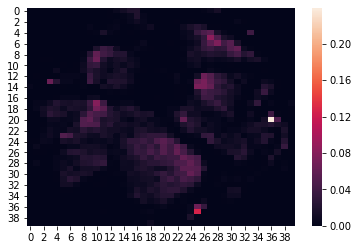

In [429]:
sns.heatmap(X_train[0,0,:])

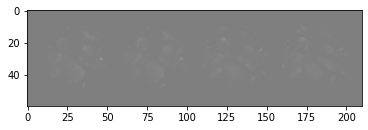

In [430]:
img_grid = torchvision.utils.make_grid(torch.from_numpy(X_train[:4,[0],:,:]), padding=10)
writer.add_image('test_image', img_grid)
matplotlib_imshow(img_grid)

In [431]:
import butterfly.deepinsight.deepinsight
m = butterfly.deepinsight.deepinsight.DeepInsight(
    input_dim=X_train.shape[2:],
    kernel_size1=1, kernel_size2=2, n_initial_filters=1)


# dataiter = iter(dataloader_train)
# images, labels = dataiter.next()

# writer.add_graph(m, images[:4,:])
# writer.flush()

In [432]:
# # embeddings
# # Bugfix: https://github.com/pytorch/pytorch/issues/30966
# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# features = images.view(-1, 40 * 40)
# writer.add_embedding(features,
#                     metadata=labels,
#                     label_img=images.unsqueeze(1))
# writer.close()

In [433]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(m.parameters(), lr=0.001, momentum=0.9, )
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)

pbar = tqdm(range(500))
for epoch in pbar:  # loop over the dataset multiple times

    m.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = m(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        every = 1
        if i % every == every - 1:
            
            m.eval()
            
            with torch.no_grad():
                loss_val = sum(criterion(m(x), y) for x, y in dataloader_val)
                loss_val /= len(dataloader_val)
                
            loss_train = running_loss / every
            writer.add_scalars("loss", dict(train=loss_train, validation=loss_val), epoch * len(dataloader_train) + i)
            running_loss = 0.0
            
            pbar.set_description(f"Processing [epoch={epoch}, batch={i:2d}] training_loss={running_loss / every:.03f}")
            
            m.train()
        
            
print('Finished Training`')

Processing [epoch=499, batch= 0] training_loss=0.000: 100%|██████████| 500/500 [00:22<00:00, 22.68it/s]

Finished Training`


In [434]:
X_train.shape

(36, 1, 40, 40)

In [435]:
X_test.shape

(6, 1, 40, 40)

# Evaluation

In [436]:
y_pred_proba = m(torch.tensor(X_train).float())
y_pred = np.argmax(y_pred_proba.detach().numpy(), axis=1)
print(sklearn.metrics.accuracy_score(y_train, y_pred))
print(sklearn.metrics.roc_auc_score(y_train, y_pred_proba[:,1].detach()))

0.5555555555555556
0.6604938271604939


In [437]:
y_pred_proba = m(torch.tensor(X_val).float())
y_pred = np.argmax(y_pred_proba.detach().numpy(), axis=1)
print(sklearn.metrics.accuracy_score(y_val, y_pred))
print(sklearn.metrics.roc_auc_score(y_val, y_pred_proba[:,1].detach()))

0.6666666666666666
0.6666666666666667


In [438]:
y_pred_proba = m(torch.tensor(X_test).float())
y_pred = np.argmax(y_pred_proba.detach().numpy(), axis=1)
print(sklearn.metrics.accuracy_score(y_test, y_pred))
print(sklearn.metrics.roc_auc_score(y_test, y_pred_proba[:,1].detach()))

0.6666666666666666
0.6666666666666667


In [439]:
import sklearn.ensemble
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [440]:
print(sklearn.metrics.accuracy_score(y_train, rf.predict(X_train.reshape(X_train.shape[0], -1))))
print(sklearn.metrics.roc_auc_score(y_train, rf.predict_proba(X_train.reshape(X_train.shape[0], -1))[:,1]))

1.0
1.0


In [441]:
print(sklearn.metrics.accuracy_score(y_val, rf.predict(X_val.reshape(X_val.shape[0], -1))))
print(sklearn.metrics.roc_auc_score(y_val, rf.predict_proba(X_val.reshape(X_val.shape[0], -1))[:,1]))

0.3333333333333333
0.4444444444444445


In [442]:
print(sklearn.metrics.accuracy_score(y_test, rf.predict(X_test.reshape(X_val.shape[0], -1))))
print(sklearn.metrics.roc_auc_score(y_test, rf.predict_proba(X_test.reshape(X_val.shape[0], -1))[:,1]))

0.3333333333333333
0.4444444444444445


In [443]:
import sklearn.ensemble
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
rf.fit(
    np.concatenate([X_train.reshape(X_train.shape[0], -1), X_val.reshape(X_val.shape[0], -1)]), 
    np.concatenate([y_train, y_val]))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [444]:
print(sklearn.metrics.accuracy_score(y_train, rf.predict(X_train.reshape(X_train.shape[0], -1))))
print(sklearn.metrics.roc_auc_score(y_train, rf.predict_proba(X_train.reshape(X_train.shape[0], -1))[:,1]))

1.0
1.0


In [445]:
print(sklearn.metrics.accuracy_score(y_val, rf.predict(X_val.reshape(X_val.shape[0], -1))))
print(sklearn.metrics.roc_auc_score(y_val, rf.predict_proba(X_val.reshape(X_val.shape[0], -1))[:,1]))

1.0
1.0


In [446]:
print(sklearn.metrics.accuracy_score(y_test, rf.predict(X_test.reshape(X_val.shape[0], -1))))
print(sklearn.metrics.roc_auc_score(y_test, rf.predict_proba(X_test.reshape(X_val.shape[0], -1))[:,1]))

1.0
1.0


# Skorch

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F

from skorch import NeuralNetClassifier


X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)

class MyModule(nn.Module):
    def __init__(self, num_units=10, nonlin=F.relu):
        super(MyModule, self).__init__()

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X


butterfly.deepinsight.deepinsight.DeepInsight(
    input_dim=X_train.shape[2:],
    kernel_size1=1, kernel_size2=2, n_initial_filters=1)
    
net = NeuralNetClassifier(
    butterfly.deepinsight.deepinsight.DeepInsight,
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

net.fit(X, y)
y_proba = net.predict_proba(X)

/home/mgbckr/miniconda3/envs/analysis3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


NameError: name 'butterfly' is not defined